
In this project, we would focus on combining RFM (Recency Frequency Monetary) Analysis with Clustering analysis to to identify different market segments .  All of the graphs and code can be found in the MBAN GitHub repository, feel free to download it and modify the numbers for your use case.

The Jupyter notebook can be opened in the executable environment binder.


# Business Problem 
-------

Customer Analytics is important to run a successful business. Sales and marketing resources are finite and expensive, therefore it is important to answer these questions when developing a marketing strategy.

* Who are our most/least valuable customers?
* How can we acquire new customers that resemble our most valuable?

The project on [RFM analysis](https://master-of-business-analytics.github.io/Website/RFM_Analysis.html) provided a basic model that allows the business to segment its customers based on three criteria based on an existing customer’s transaction history; recency of Customer's Last purchase, frequency of purchases and total amount spent, which is referred to as monetary.
However this analysis approaches this problem with the 2 steps approach mentioned below:

1. Data is extracted to RFM model and then clustering based on RFM principle.
2. Clustering using k-Means algorithm.

## Data Set

There are  eight variables in the data set:

1. InvoiceNo: Invoice number,  A 6-digit integral number uniquely assigned to each transaction.
2. StockCode: Product code, a 5-digit integral number uniquely assigned to each distinct product.
3. Description: Product name
4. Quantity: The quantities of each product (item) per transaction.
5. InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
6. UnitPrice: Unit price. Numeric, Product price per unit in sterling.
7. CustomerID: Customer number, a 5-digit integral number uniquely assigned to each customer.
8. Country 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
#ignore warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

#load data
url = 'https://raw.githubusercontent.com/Master-of-Business-Analytics/Project_06_RFM_Analysis/master/data.csv'
df = pd.read_csv(url, error_bad_lines=False,encoding= 'unicode_escape')




In [2]:
#summary of dataset
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,540558,21258,?,-29,1/10/2011 10:04,0.00,NaN,United Kingdom
1,540560,21589,NaN,-14,1/10/2011 10:08,0.00,NaN,United Kingdom
2,540561,22343,PARTY PIZZA DISH RED RETROSPOT,24,1/10/2011 10:32,0.21,13004.0,United Kingdom
3,540561,22344,PARTY PIZZA DISH PINK POLKADOT,24,1/10/2011 10:32,0.21,13004.0,United Kingdom
4,540561,47504H,ENGLISH ROSE SPIRIT LEVEL,24,1/10/2011 10:32,0.85,13004.0,United Kingdom


# Data cleaning 

The dataset seemed relatively clean at first glance, but it was actually riddled with errors. There were quite a number of these positive/negative offsetting entries throughout the dataset, plus other apparent errors such as customers with negative transactions. More information on data cleaning can be found on the [data cleaning project](https://master-of-business-analytics.github.io/Website/Data_Cleaning.html).

The first step in cleaning the dataset is to check if there are any missing values and where the missing values are located.

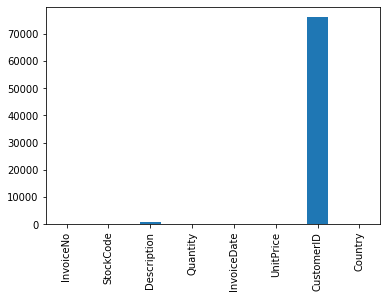

In [202]:

#Visualize the number of null values in the dataframe for each column
df.isnull().sum().plot(kind='bar')

The bar chart above shows that NaN values are located at the description and customer ID column. The purpose of this evaluating is current customer segmentation therefore transactions without customer ID does not provide any value and are dropped from the data frame below.  

In [3]:
#Eliminating rows with NA
#df=df[df.notnull().all(axis=1)] 
df=df.dropna(subset=['CustomerID'])
#NA stutus accross columns
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

The summary table shows that very low negative values under the quantity values. Further analysis show that the minimum and maximum values have the same absolute values. This could be as a result of a mistake in data entry. There are two ways data input error is usually corrected; entering a value with the opposite sign to nullify the previous mistake or entering the difference between actual actual transaction and previous entry. 

The first instance corrected by:
1. Confirming that both transactions are for one customer and drop the rows if true. 
2. Repeating the previous step until the the minimum and maximum quantity values do not have the same absolute values.

In [4]:
#selecting relevant columns
df2 = df[['InvoiceDate',"CustomerID",'StockCode','UnitPrice','Quantity']]
#snapshoot of new dataframe
df2.head()

,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity
2,1/10/2011 10:32,13004.0,22343,0.21,24
3,1/10/2011 10:32,13004.0,22344,0.21,24
4,1/10/2011 10:32,13004.0,47504H,0.85,24
5,1/10/2011 10:32,13004.0,84509G,1.25,12
6,1/10/2011 10:32,13004.0,22720,4.95,3


In [5]:
#row data of maximum and minimum data
df2.loc[[df2['Quantity'].idxmax(),df['Quantity'].idxmin()]]

,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity
188958,12/9/2011 9:15,16446.0,23843,2.08,80995
188959,12/9/2011 9:27,16446.0,23843,2.08,-80995


In [6]:
#remove containing row minimum and maximum quantity as it is basically a duplicate
df2.drop(index=[df2['Quantity'].idxmax(), df2['Quantity'].idxmin()], inplace=True)

#chack minimum and maximum quantity 
df2.describe()

,CustomerID,UnitPrice,Quantity
count,214537.000000,214537.000000,214537.000000
mean,15528.114199,3.048388,10.561642
std,1592.765139,14.165101,232.168351
min,12346.000000,0.000000,-74215.000000
25%,14159.000000,1.250000,2.000000
50%,15493.000000,1.950000,4.000000
75%,16923.000000,3.750000,12.000000
max,18287.000000,3155.950000,74215.000000


<b> Repeat Process </b>

In [7]:

#row data of maximum and minimum data
df2.loc[[df2['Quantity'].idxmax(),df2['Quantity'].idxmin()]]

,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity
10537,1/18/2011 10:01,12346.0,23166,1.04,74215
10542,1/18/2011 10:17,12346.0,23166,1.04,-74215


<b>Note that the Minimum quantity and Maximum quantity have the same absolute values.</b>

In [8]:
#remove containing row minimum and maximum quantity as it is basically a duplicate
df2.drop(index=[df2['Quantity'].idxmax(), df2['Quantity'].idxmin()], inplace=True)

#chack minimum and maximum quantity 
df2.describe()

,CustomerID,UnitPrice,Quantity
count,214535.000000,214535.000000,214535.000000
mean,15528.143865,3.048407,10.561741
std,1592.742929,14.165166,50.550843
min,12747.000000,0.000000,-3114.000000
25%,14159.000000,1.250000,2.000000
50%,15493.000000,1.950000,4.000000
75%,16923.000000,3.750000,12.000000
max,18287.000000,3155.950000,12540.000000


<b> Note that the Minimum quantity and Maximum quantity do not have the same absolute values.</b>

The next step is to change the date column and add the total sales column

In [9]:
# Convert InvoiceDate from object to datetime format
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])

#remove minutes and seconds from date
df2['InvoiceDate'] = df2.InvoiceDate.dt.date
                        
#creating a total sales column
df2["Totalsum"] = df2['Quantity'] * df2['UnitPrice']

df2.head(5)

,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity,Totalsum
2,2011-01-10,13004.0,22343,0.21,24,5.04
3,2011-01-10,13004.0,22344,0.21,24,5.04
4,2011-01-10,13004.0,47504H,0.85,24,20.40
5,2011-01-10,13004.0,84509G,1.25,12,15.00
6,2011-01-10,13004.0,22720,4.95,3,14.85


In [10]:
# information about the data set
print('{:,} rows; {:,} columns'
      .format(df.shape[0], df.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(df[df.CustomerID.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(df['InvoiceDate'].min(),
                                    df['InvoiceDate'].max()))

214,539 rows; 8 columns
0 transactions don't have a customer id
Transactions timeframe from 1/10/2011 10:32 to 5/20/2011 14:06


# RFM model

The RFM model describes current customers historical purchase behavior using 3 feature:

* When did the customer make their last purchase?
* How often does the customer make a purchase?
*  How much money does the customer spend?

The general assumption with the RFM model is that Customers that purchase in shorter time intervals in
greater volumes at higher prices are more like to respond positively to future engagement and product offers.  


The customer records are grouped by recency of their purchase, the frequency by their quantity, and the monetary value of the purchases. 

In [11]:
# create a table that aggregates the transactions by customer id to 
# obtain recency score, frequency of purchase and monetary value


# set current date as most recent date plus one day
df2['snapshot'] = df2['InvoiceDate'] + timedelta(days=1)  

#group customers by their most recent purchase
snapshot_date = df2['InvoiceDate'].max() + timedelta(days=1)  

#creat recency table by comparing most recent transaction to snapshot date by customer ID
rec_df = snapshot_date-df2.groupby("CustomerID").agg({"InvoiceDate":max}) 

#renaming column names
rec_df.rename(columns={"InvoiceDate": "Recency"}, inplace=True)#rename column
rec_df=rec_df["Recency"].apply(lambda x: x.days) #extracting number of days only

#creating frequency and monetary table by grouping number of purchases and total money spent by customer ID
fmTable = df2.groupby('CustomerID').agg({'CustomerID': lambda x: len(x),               # Frequency
                                        'Totalsum': lambda x: x.sum()})          # Monetary Value
#renaming column names
fmTable.rename(columns={
                         'CustomerID': 'Frequency', 
                         'Totalsum': 'Monetary'}, inplace=True)

#combining the fm table and the recency table

rfm_df = pd.concat([rec_df,fmTable],axis=1)

rfm_df.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12747.0,3,50.0,2040.43
12748.0,1,2729.0,15727.57
12749.0,4,114.0,2194.75
12820.0,4,45.0,724.57
12823.0,255,3.0,994.50


# Cluster Analysis 
Clustering is the process of dividing the entire data into groups (also known as clusters) based on the patterns in the data.

The k-means clustering technique is an algorithm that tries to minimize the distance of the points in a cluster with their centroid. There are two steps in cluster analysis:

1. Finding the optimal number of clusters : the number of cluster value where this decrease in inertia value becomes constant can be chosen as the right number of cluster for our data.

2.Fit to kmeans model


 
Looking at the rfm data table above,  there is a lot of variation in the magnitude of the data. Since K-Means is a distance-based algorithm, this difference of magnitude can create a problem,therefore all the variables are standardized to the same magnitude using the RFM scores:

In [12]:
# standardizing the data

# --Calculate R and F groups--
rfm_df1= rfm_df.copy()

# Create labels for Recency and Frequency and MonetaryValue
r_labels = range(4, 0, -1) #[4,3,2,1] 
f_labels = range(1, 5)   #[1,2,3,4]
m_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm_df1['Recency'], q=4, labels=r_labels)
# Assign these labels to1111 4 equal percentile groups 
f_groups = pd.qcut(rfm_df1['Frequency'], q=4, labels=f_labels)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(rfm_df1['Monetary'], q=4, labels=m_labels)



# Create new columns R_score, M_score and F_score  
rfm_df1 = rfm_df1.assign(R_score = r_groups.values, F_score = f_groups.values, M_score = m_groups.values)
rfm_df1 = rfm_df1[['R_score','F_score','M_score']]
rfm_df1.head()

,R_score,F_score,M_score
CustomerID,,,
12747.0,4,3,4
12748.0,4,4,4
12749.0,4,4,4
12820.0,4,3,3
12823.0,1,1,3


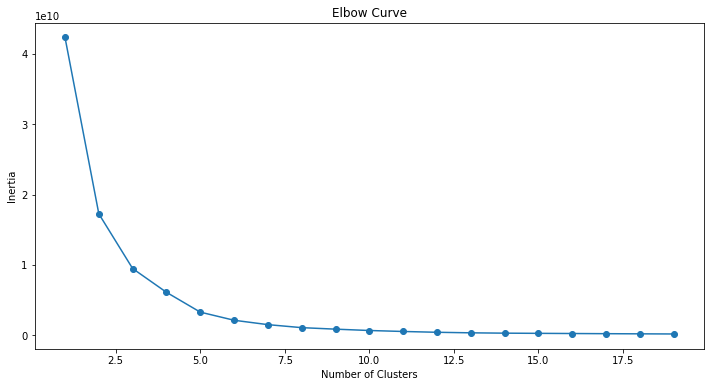

In [60]:

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(rfm_df).inertia_ for i in range(len(kmeans))]


plt.figure(figsize=(12,6))
plt.plot(Nc,score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

<b>Looking at the above elbow curve, we can choose any number of clusters between 2.5 to 5. The number of clusters is set as 4 and fit the model</b>

In [65]:
#fitting data in Kmeans theorem.
kmeans = KMeans(n_clusters=4, random_state=0).fit(rfm_df)

# creates a new column called cluster which has cluster number for each row.
rfm_df['cluster'] = kmeans.labels_
rfm_df.head(15)

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12747.0,3,50.0,2040.43,0
12748.0,1,2729.0,15727.57,1
12749.0,4,114.0,2194.75,0
12820.0,4,45.0,724.57,0
12823.0,255,3.0,994.50,0
12824.0,60,25.0,397.12,0
12826.0,3,62.0,964.20,0
12827.0,6,25.0,430.15,0
12828.0,3,31.0,603.20,0


In [64]:
rfm_df.cluster.value_counts()

0    3210
1      54
3       9
2       1
Name: cluster, dtype: int64

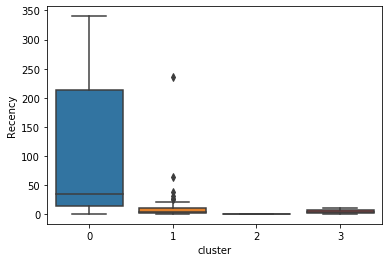

In [66]:

sns.boxplot(rfm_df.cluster,rfm_df.Recency)

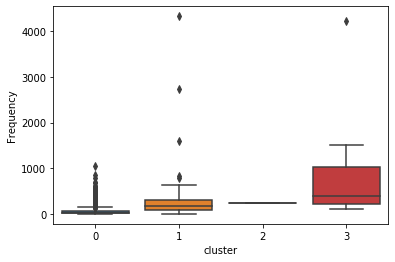

In [67]:
sns.boxplot(rfm_df.cluster,rfm_df.Frequency)

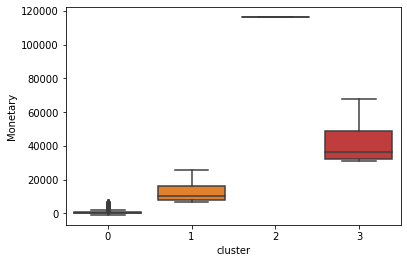

In [68]:
sns.boxplot(rfm_df.cluster,rfm_df.Monetary)

# Final Conclusion

On the basis of the RFM model, customers of the business have been segmented into various meaningful groups. Using the clustering algorithm, and the main characteristics of the consumers in each segment have been clearly identified.

# Reference 

1. https://www.moengage.com/blog/rfm-analysis-using-predictive-segments/
2. https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
3. https://earlconf.com/2017/downloads/london/presentations/EARL2017_-_London_-_Alexander_Campbell_-_Customer_segmentation.pdf
4. https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/#k-means-clustering-python-code
5. https://www.kaggle.com/yugagrawal95/rfm-analysis